In [1]:
%%file data.scons

# Get data
Fetch('horizon.asc','hall')

# Convert format
Flow('data','horizon.asc',
     '''
     echo in=$SOURCE data_format=ascii_float n1=3 n2=57036 | 
     dd form=native | window n1=1 f1=-1 | add add=-65 | 
     put 
     n2=291 o2=35.031 d2=0.01 label2=y unit2=km 
     n1=196 o1=33.139 d1=0.01 label1=x unit1=km |
     costaper nw1=25 nw2=25 
     ''')

# Display
def plot(title):
    return '''
    grey color=j title="%s" 
    transp=y yreverse=n clip=14
    ''' % title
Result('data',plot('Horizon'))

Writing data.scons


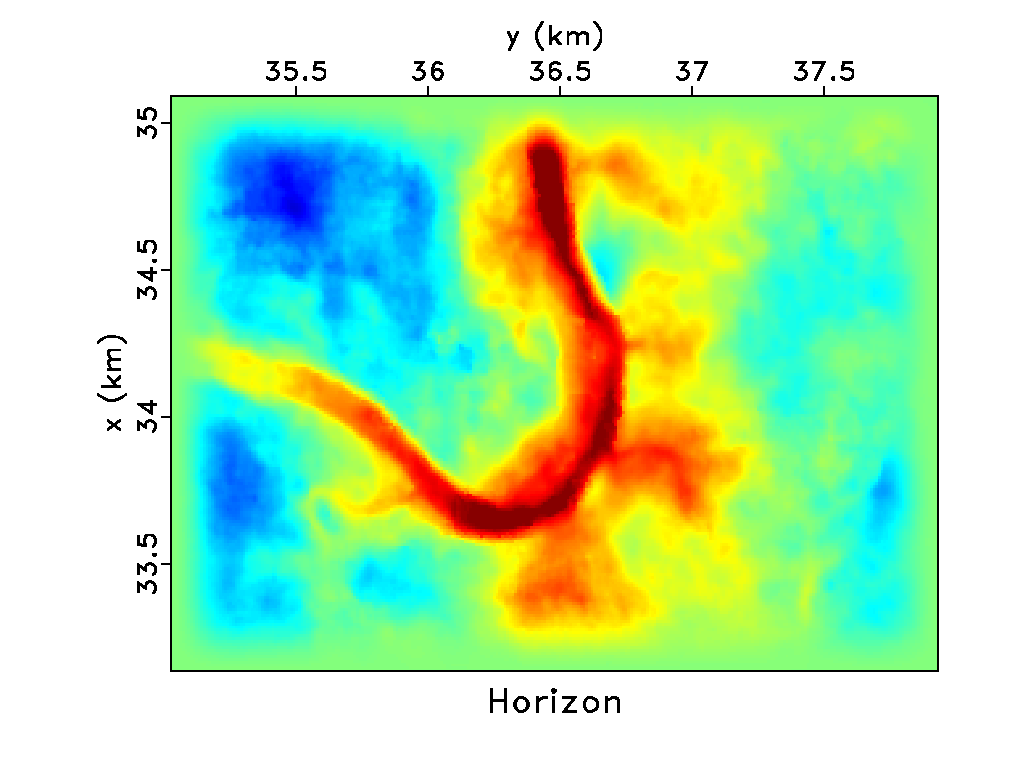

In [2]:
from m8r import view
view('data')

In [3]:
%%file fft.scons

# 2-D Fourier Transform
Flow('fft','data',
     'rtoc | fft3 axis=1 pad=1 | fft3 axis=2 pad=1')
Result('fft',
       '''
       math output="abs(input)" | real | 
       grey title="Fourier Transform" allpos=y screenratio=1
       ''')

Writing fft.scons


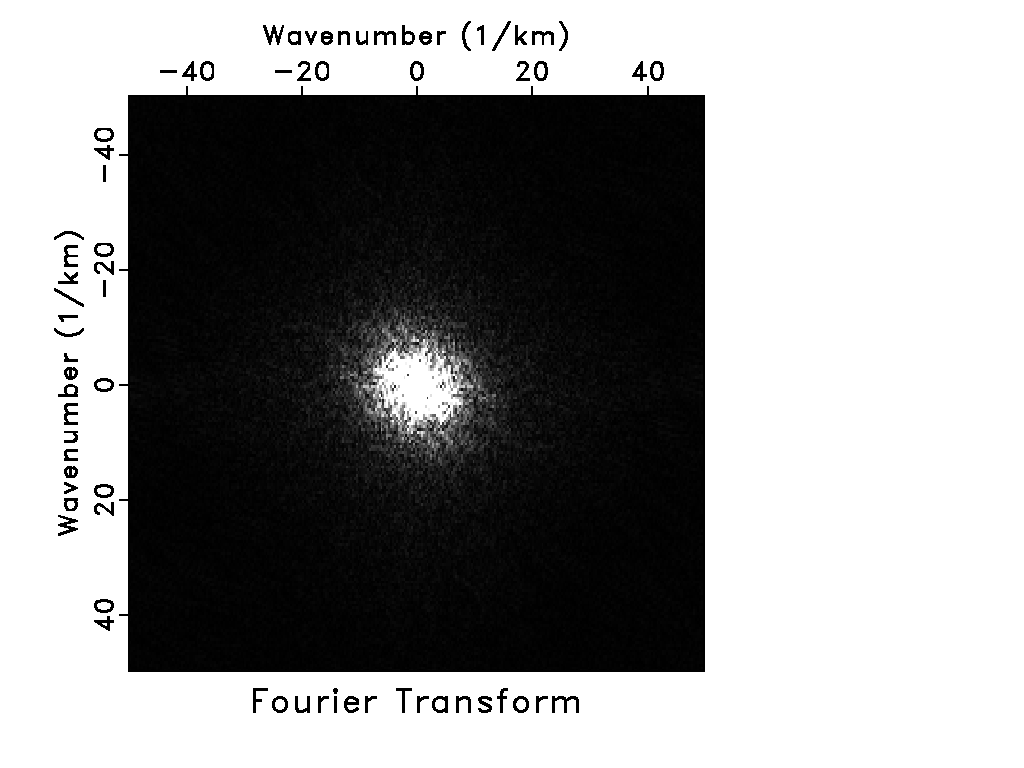

In [4]:
view('fft')

In [9]:
%%file dwt.scons

# 2-D Digital Wavelet Transform

Flow('dwt','data',
     '''
     transp | dwt type=b | transp | dwt type=b |
     put 
     label1=Scale unit1= o1=0 d1=1 
     label2=Scale unit2= o2=0 d2=1
     ''')
Result('dwt',
       '''
       math output="abs(input)" | 
       grey title="Wavelet Transform" allpos=y screenratio=1
       ''')

Overwriting dwt.scons


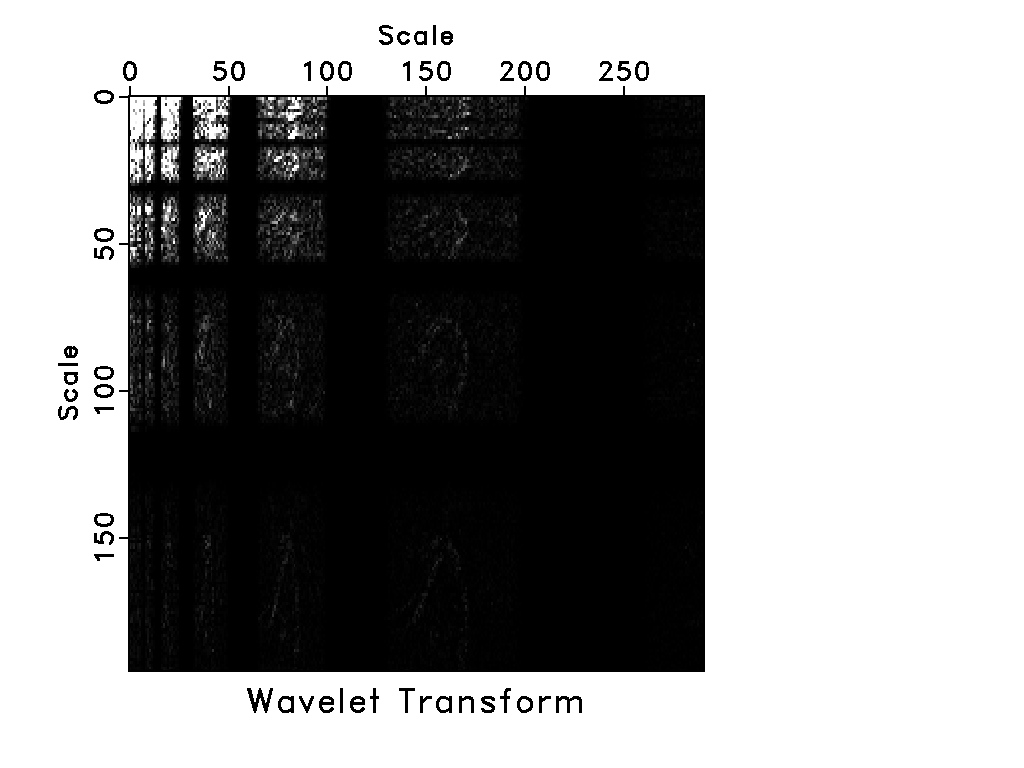

In [10]:
view('dwt')

In [15]:
%%file compression.scons

# Comparing coefficient decay
Flow('fftcoef','fft',
     'put n1=60000 o1=1 d1=1 n2=1 unit1= unit2= | sort')
Flow('dwtcoef','dwt',
     '''
     pad n1=200 n2=300 | 
     put n1=60000 o1=1 d1=1 n2=1 unit1= unit2= | 
     sort
     ''')

Result('coef','fftcoef dwtcoef',
       '''
       cat axis=2 ${SOURCES[1]} |
       window n1=5000 |
       scale axis=1 |
       math output="10*log(input)/log(10)" |
       graph dash=1,0 label1=n label2="a\_n\^" unit2="DB" wanttitle=n 
       ''')

Overwriting compression.scons


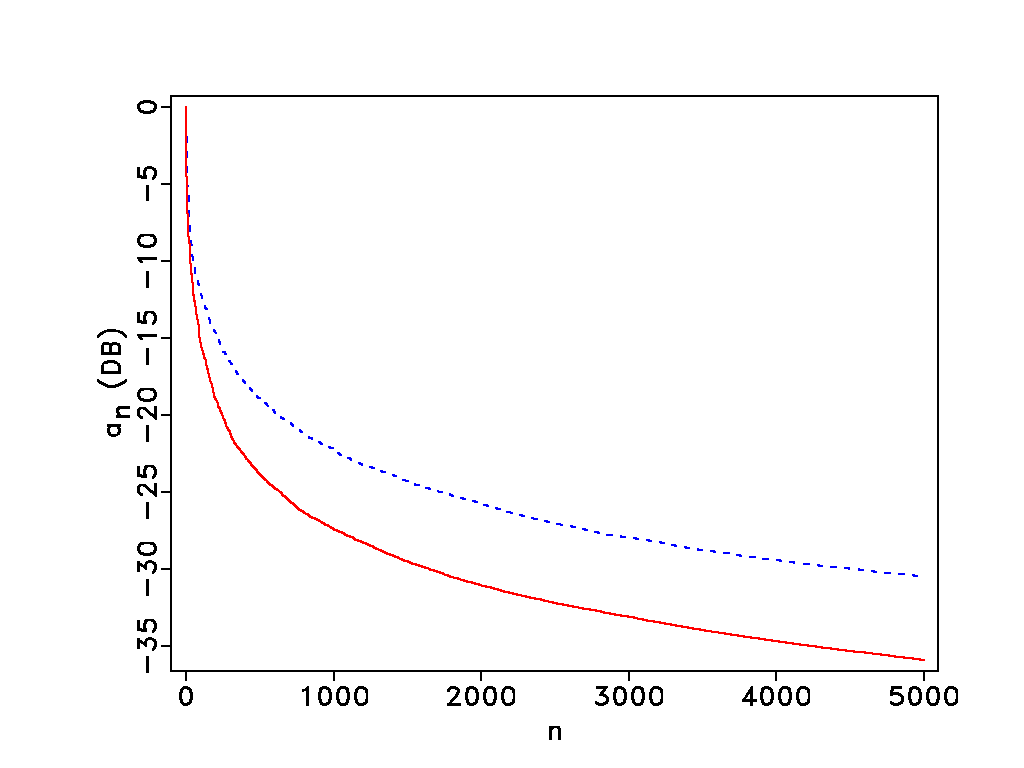

In [16]:
view('coef')

In [37]:
%%file hole.scons

# Cut three square holes 
cut = '''
cut n1=20 n2=20 f1=125 f2=150 | 
cut n1=20 n2=20 f1=150 f2=50  | 
cut n1=20 n2=20 f1=75  f2=175
'''

Flow('hole','data',cut)
Flow('mask','data',
     'math output=1 | %s | math output=1-input' % cut)
Result('hole',plot('Input'))

Overwriting hole.scons


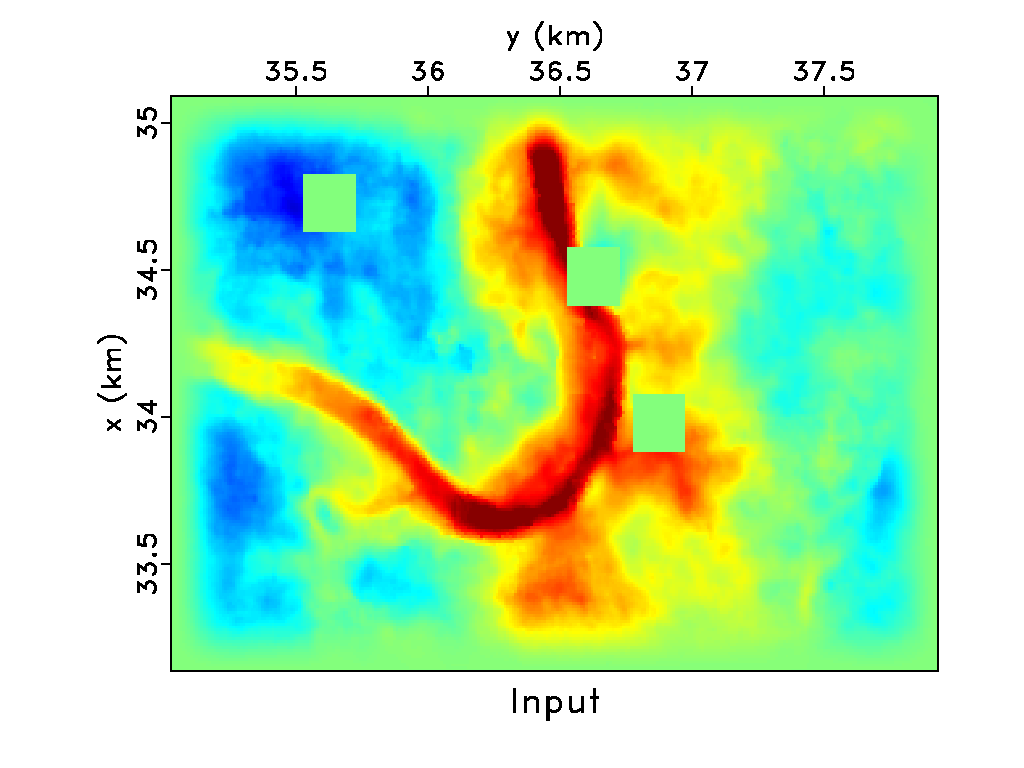

In [44]:
view('hole')

In [19]:
%%file dwthole.scons

# 2-D Digital Wavelet Transform

Flow('dwth','hole',
     '''
     transp | dwt type=b | transp | dwt type=b |
     put 
     label1=Scale unit1= o1=0 d1=1 
     label2=Scale unit2= o2=0 d2=1
     ''')
Result('dwth',
       '''
       math output="abs(input)" | 
       grey title="Wavelet Transform" allpos=y screenratio=1
       ''')

Writing dwthole.scons


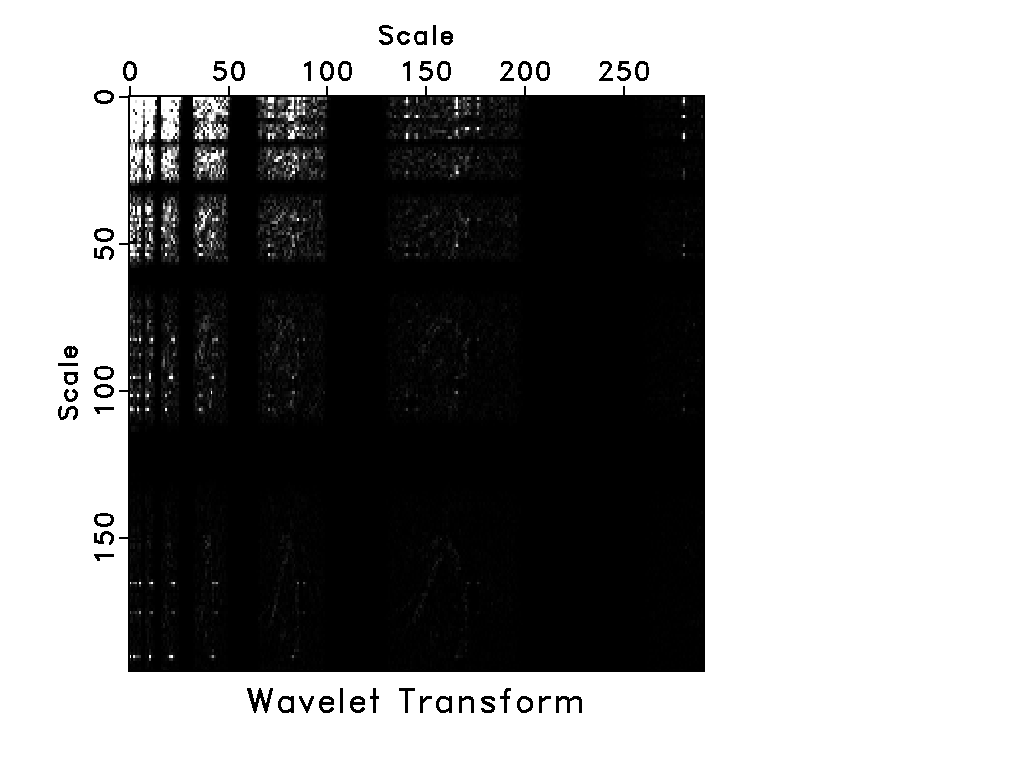

In [20]:
view('dwth')

In [76]:
%%file ista.scons

# Shaping regularization (iterative thresholding)

# m_{n+1} = S[(I-K) m_n + m_0]

m0 = 'hole'
m = m0

for i in range(100):
    mi = 'shape%d' % i
    Flow(mi,[m,'mask',m0],
         '''
         mul ${SOURCES[1]} |
         add ${SOURCES[2]} |
         pad n1=256 n2=512 |
         transp | dwt type=b inv=y | 
         transp | dwt type=b inv=y |
         threshold pclip=1 |
         dwt type=b inv=y adj=y | transp | 
         dwt type=b inv=y adj=y | transp |
         window n1=196 n2=291
         ''')
    m = mi
Result('fill',m,plot('Reconstruction'))

Overwriting ista.scons


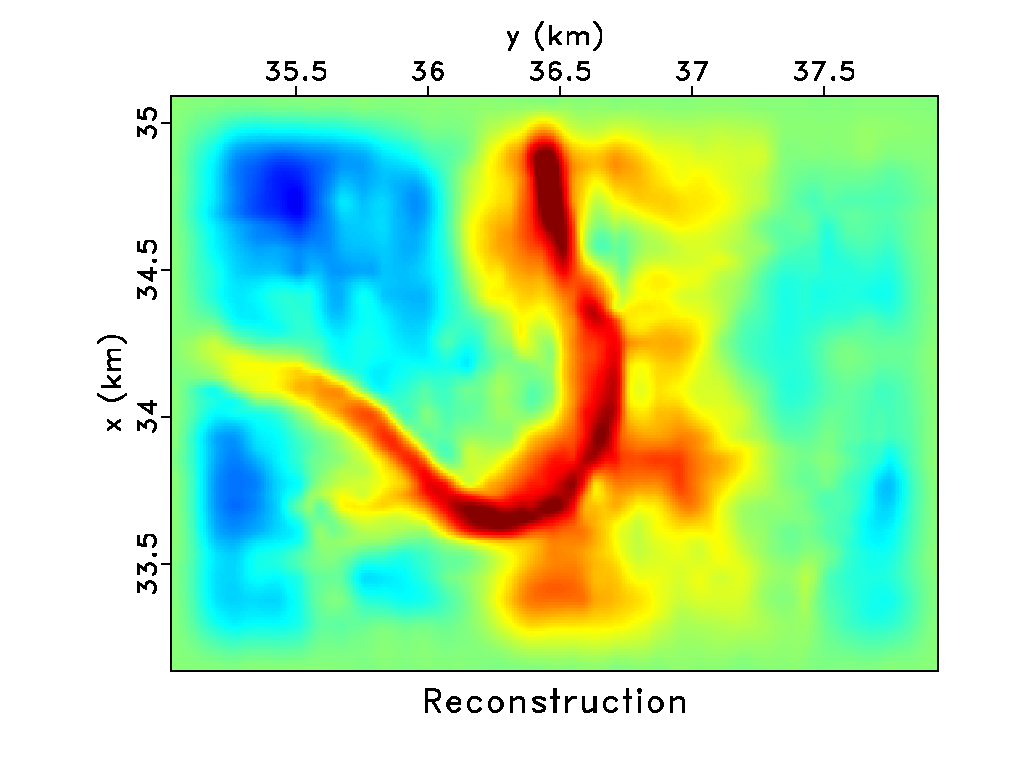

In [77]:
view('fill')